In [1]:
import numpy as np
from math import sqrt, exp
from matplotlib import pyplot as plt

In [2]:
def get_stages(yn, A, c, h, t, f):
    # f = function
    s = len(c) # number of stages
    m = len(yn) # number of differential equations in system
    k = np.zeros([s, m]) # initialize empty array for stages
    k[0] = f(t + c[0] * h, yn) # initial stage k1
    # Compute stages k2, k3, k4, ... 
    for i in range(1, s):
        sum_prevStages = sum([A[i][j] * k[j] for j in range(i)])
        k[i] = f(t + c[i] * h, yn + h * sum_prevStages) 
    return k

def runge_kutta_solver(yn, A, b, c, h, t, f):
    # yn = approx. sol. of prev. timepoint
    # A = spatial shift matrix
    # b = averaging weight vector of length s (s = #stages)
    # c = temporal shift vector of length s 
    s = len(c) # number of stages
    k = get_stages(yn, A, c, h, t, f)
    y_nplus1 = yn + h * sum([b[i] * k[i] for i in range(s)]) # compute approx. solution y of next time point
    return y_nplus1
    

def rk_time_stepper(y0, A, b, c, h, t0, tf, f):
    # Call the runge kutta solver for all time points
    time = np.arange(t0, tf+h, h);
    N = len(time) # total number of time steps
    y_all_timesteps = np.zeros([N, len(y0)]) # initialize empty array for solutions of all time steps
    y_all_timesteps[0] = y0 # initial condition
    for n in range(1, N):
        y_all_timesteps[n] = runge_kutta_solver(y_all_timesteps[n-1], A, b, c, h, time[n], f);
    return time, y_all_timesteps
    
    

In [3]:
def two_body_problem(t, y):
    y1, y2, y3, y4 = y
    dy1 = y3
    dy2 = y4
    dy3 = - y1 / ( (y1**2 + y2**2)**(3/2) )
    dy4 = - y2 / ( (y1**2 + y2**2)**(3/2) )
    return [dy1, dy2, dy3, dy4]

In [4]:
# Butcher table Heun's Method
A_heun = [[0, 0],[1, 0]]
b_heun = [0.5, 0.5]
c_heun = [0, 1]

In [5]:
# Initial values
y0 = [0.5, 0, 0, sqrt(3)]

# Parameters
t0 = 0
tf = 8
h1 = 0.1
h2 = 0.01

In [6]:
# Solve 2-body-problem using Heun's Method
time_h1, y_rk_h1 = rk_time_stepper(y0, A_heun, b_heun, c_heun, h1, t0, tf, two_body_problem)
time_h2, y_rk_h2 = rk_time_stepper(y0, A_heun, b_heun, c_heun, h2, t0, tf, two_body_problem)

In [7]:
y_rk_h1[0:3, :]

array([[ 0.5       ,  0.        ,  0.        ,  1.73205081],
       [ 0.48      ,  0.17320508, -0.36873414,  1.67359959],
       [ 0.42506525,  0.33404772, -0.67627167,  1.51087874]])

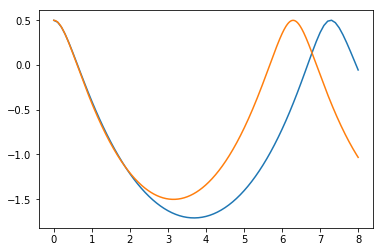

In [8]:
plt.plot(time_h1, y_rk_h1[:, 0])
plt.plot(time_h2, y_rk_h2[:, 0])

In [9]:
#Butcher Tables
A_Euler=np.array([0])
b_Euler=np.array([1])
c_Euler=np.array([0])

A_Heun=np.array([[0,0],[1,0]])
b_Heun=np.array([0.5,0.5])
c_Heun=np.array([0,1])

A_RK3=np.array([[0,0],[2.0/3,0]])
b_RK3=np.array([1.0/4,3.0/4])
c_RK3=np.array([0,2/3.0])

A_RK4=np.array([[0,0,0],[0.5,0,0],[0,0.5,0],[0,0,1]])
b_RK4=np.array([1/6.,1/3.,1/3.,1/6.])
c_RK4=np.array([0,1/2.,1/2.,1])

In [10]:
def ode(t, x):
    # M: nxn matrix, x: nx1 vector
    M = np.array([[-1001, 999],[999, -1001]])
    return M@x

In [11]:
# x0 = np.array([-1, 1])
# x0 = np.array([1, 1])
x0 = np.array([2, 0])

In [12]:
N = 1000
h = 1/N
t0 = 0
tf = t0 + N*h
# time_ode, y_rk_ode = rk_time_stepper(x0, A_Euler, b_Euler, c_Euler, h, t0, tf, ode)
time_ode, y_rk_ode = rk_time_stepper(x0, A_RK4, b_RK4, c_RK4, h, t0, tf, ode)

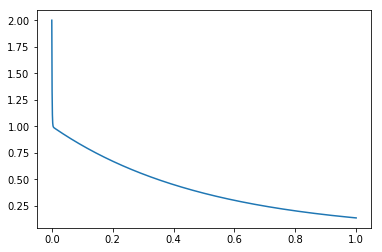

In [13]:
plt.plot(time_ode, y_rk_ode[:,0])

In [14]:
def exact_solution_ode(t, x0):
    x1 = 0.5 * (x0[0] - x0[1]) * exp(-2000 * t) + 0.5 * (x0[0] + x0[1]) * exp(-2 * t)
    x2 = 0.5 * (x0[1] - x0[0]) * exp(-2000 * t) + 0.5 * (x0[0] + x0[1]) * exp(-2 * t)
    return np.array([x1, x2])

In [15]:
x_exact = np.zeros([N+1, len(x0)])
x_exact[0] = x0
for i in range(1, N+1):
    x_exact[i] = exact_solution_ode(time_ode[i], x0)

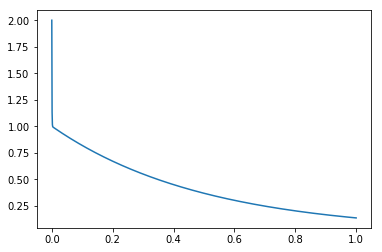

In [16]:
plt.plot(time_ode, x_exact[:,0], "-")

In [17]:
# Adaptive step size
def adaptive_step_size(x, x_hat, TOL, Fs, p, h):
    l = np.linalg.norm(np.array([x[i] - x_hat[i] for i in range(len(x))])) # local error estimator
    # if the local error is higher than the tolerance, reject x (return false) and reduce the step size h
    if l > TOL: 
        h = h * (TOL/l)**(1/(1+p)) * Fs
        return False, h
    
    # if the local error is <= tolerance, accept x (return true) and propose new, larger h for next step
    if l <= TOL:
        h = h * (TOL/l)**(1/(1+p)) * Fs
        return True, h

In [18]:
# Runge Kutta Method with dynamic step-size adaptation: Embedded Runge-Kutta method
def embedded_runge_kutta_stepper(y0, A, b, c, b_hat, h, t0, tf, f, TOL, Fs, p):

    # initialize list for solutions of all time steps for y and reference y_hat and pass initial value
    y_all_timesteps = [y0]
    y_all_timesteps_hat = [y0]
    time = [t0] # list for all the time-points computed. Will be returned.
    t = t0 # intialize time iterator with starting time t0
    i = 0
    accepted = False
    while t <= tf:
        # Compute y and y_hat for different h until they are accepted (error below tolerance)
        y = runge_kutta_solver(y_all_timesteps[i], A, b, c, h, t, f);
        y_hat = runge_kutta_solver(y_all_timesteps_hat[i], A, b_hat, c, h, t, f);
        
        accepted, h = adaptive_step_size(y, y_hat, TOL, Fs, p, h)
        
        if accepted:
            print("Iteration %d: Accepted y_n+1. New h for next iteration: %f" %(i, h))
            # if the local error of the solution is <= tolerance, accept y and y_hat and add to list
            # else repeat computation with new h
            y_all_timesteps += [y]
            y_all_timesteps_hat += [y_hat]
            t += h
            time += [t]
            i += 1 # number of time steps (iterator for accessing list for prev. solution)
            
    return time, y_all_timesteps, y_all_timesteps_hat
    

In [19]:
A_DOPRI5=np.array([[0,0,0,0,0,0,0],[1/5,0,0,0,0,0,0],[3/40,9/40,0,0,0,0,0],[44/45,-56/15,32/9,0,0,0,0],[19372/6561,-25360/2187,64448/6561,-212/729,0,0,0],[9017/3168,-355/33,46732/5247,49/176,-5103/18656,0,0],[35/384.,0,500/1113,125/192,-2187/6784,11/84,0]])
b_DOPRI5=np.array([35/384.,0,500/1113,125/192,-2187/6784,11/84,0])
b_hat_DOPRI5=np.array([5179/57600,0,7571/16695,393/640,-92097/339200,187/2100,1/40])
c_DOPRI5=np.array([0,1/5.,3/10.,4/5,8/9,1,1])

In [25]:
# SYSTEM OF ODES
# x0 = np.array([-1, 1])
# x0 = np.array([1, 1])
# x0 = np.array([2, 0])

# N = 100
# h = 1/N
# t0 = 0
# tf = t0 + N*h

# 2 BODY PROBLEM
# Initial values
x0 = [0.5, 0, 0, sqrt(3)]

# Parameters
t0 = 0
tf = 4
h = 0.01


TOL = 0.1
Fs = 0.8
p = 4
time, y, y_hat = embedded_runge_kutta_stepper(x0, A_DOPRI5, b_DOPRI5, c_DOPRI5, b_hat_DOPRI5, h, t0, tf, two_body_problem, TOL, Fs, p)

Iteration 0: Accepted y_n+1. New h for next iteration: 0.613431
Iteration 1: Accepted y_n+1. New h for next iteration: 0.536072
Iteration 2: Accepted y_n+1. New h for next iteration: 0.449705
Iteration 3: Accepted y_n+1. New h for next iteration: 0.377206
Iteration 4: Accepted y_n+1. New h for next iteration: 0.317887
Iteration 5: Accepted y_n+1. New h for next iteration: 0.267140
Iteration 6: Accepted y_n+1. New h for next iteration: 0.221685
Iteration 7: Accepted y_n+1. New h for next iteration: 0.180389
Iteration 8: Accepted y_n+1. New h for next iteration: 0.114906
Iteration 9: Accepted y_n+1. New h for next iteration: 0.000258
Iteration 10: Accepted y_n+1. New h for next iteration: 0.000005
Iteration 11: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 13: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 14: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 15: Accepted y_n+1. New h

Iteration 714: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 715: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 716: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 717: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 718: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 719: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 720: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 721: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 722: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 723: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 724: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 725: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 726: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 727: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 728: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 

Iteration 1227: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1228: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1229: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1230: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1231: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1232: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1233: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1234: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1235: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1236: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1237: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1238: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1239: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1240: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1241: Accepted y_n+1. New h for next iteration: 0.00

Iteration 1748: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1749: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1750: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1751: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1752: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1753: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1754: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1755: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1756: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1757: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1758: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1759: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1760: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1761: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1762: Accepted y_n+1. New h for next iteration: 0.00

Iteration 2319: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2320: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2321: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2322: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2323: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2324: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2325: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2326: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2327: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2328: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2329: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2330: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2331: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2332: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2333: Accepted y_n+1. New h for next iteration: 0.00

Iteration 2895: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2896: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2897: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2898: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2899: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2900: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2901: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2902: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2903: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2904: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2905: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2906: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2907: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2908: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2909: Accepted y_n+1. New h for next iteration: 0.00

Iteration 3446: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3447: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3448: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3449: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3450: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3451: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3452: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3453: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3454: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3455: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3456: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3457: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3458: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3459: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3460: Accepted y_n+1. New h for next iteration: 0.00

Iteration 3979: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3980: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3981: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3982: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3983: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3984: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3985: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3986: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3987: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3988: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3989: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3990: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3991: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3992: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3993: Accepted y_n+1. New h for next iteration: 0.00

Iteration 4555: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4556: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4557: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4558: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4559: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4560: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4561: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4562: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4563: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4564: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4565: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4566: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4567: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4568: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4569: Accepted y_n+1. New h for next iteration: 0.00

Iteration 5126: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5127: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5128: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5129: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5130: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5131: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5132: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5133: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5134: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5135: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5136: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5137: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5138: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5139: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5140: Accepted y_n+1. New h for next iteration: 0.00

Iteration 5681: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5682: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5683: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5684: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5685: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5686: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5687: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5688: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5689: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5690: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5691: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5692: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5693: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5694: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5695: Accepted y_n+1. New h for next iteration: 0.00

Iteration 6309: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6310: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6311: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6312: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6313: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6314: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6315: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6316: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6317: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6318: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6319: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6320: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6321: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6322: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6323: Accepted y_n+1. New h for next iteration: 0.00

Iteration 6920: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6921: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6922: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6923: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6924: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6925: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6926: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6927: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6928: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6929: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6930: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6931: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6932: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6933: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6934: Accepted y_n+1. New h for next iteration: 0.00

Iteration 7442: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7443: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7444: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7445: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7446: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7447: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7448: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7449: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7450: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7451: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7452: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7453: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7454: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7455: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7456: Accepted y_n+1. New h for next iteration: 0.00

Iteration 7942: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7943: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7944: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7945: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7946: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7947: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7948: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7949: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7950: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7951: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7952: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7953: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7954: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7955: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 7956: Accepted y_n+1. New h for next iteration: 0.00

Iteration 8441: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8442: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8443: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8444: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8445: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8446: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8447: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8448: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8449: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8450: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8451: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8452: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8453: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8454: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8455: Accepted y_n+1. New h for next iteration: 0.00

Iteration 8941: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8942: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8943: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8944: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8945: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8946: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8947: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8948: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8949: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8950: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8951: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8952: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8953: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8954: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 8955: Accepted y_n+1. New h for next iteration: 0.00

Iteration 9543: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9544: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9545: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9546: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9547: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9548: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9549: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9550: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9551: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9552: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9553: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9554: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9555: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9556: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 9557: Accepted y_n+1. New h for next iteration: 0.00

Iteration 10189: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10190: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10191: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10192: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10193: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10194: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10195: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10196: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10197: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10198: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10199: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10200: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10201: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10202: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10203: Accepted y_n+1. New h for next 

Iteration 10858: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10859: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10860: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10861: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10862: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10863: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10864: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10865: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10866: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10867: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10868: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10869: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10870: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10871: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 10872: Accepted y_n+1. New h for next 

Iteration 11439: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11440: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11441: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11442: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11443: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11444: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11445: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11446: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11447: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11448: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11449: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11450: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11451: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11452: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11453: Accepted y_n+1. New h for next 

Iteration 12041: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12042: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12043: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12044: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12045: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12046: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12047: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12048: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12049: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12050: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12051: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12052: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12053: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12054: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12055: Accepted y_n+1. New h for next 

KeyboardInterrupt: 

In [ ]:
plt.plot(time, y)
# plt.plot(time, y_hat)
None